# 1. Setup

## 1.1 Import Packages

In [1]:
#Import Python packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# for splitting of the dataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

# for encoding/transforming the data
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.preprocessing import MinMaxScaler

#ML-Models: Regression
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

#Building clustering model
from sklearn.cluster import KMeans 

# for getting metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

# model selection
from sklearn.model_selection import GridSearchCV

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
# Define a simple scoring function
from cachetools import cached

## 1.2 Connect to Snowflake

In [2]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [3]:
session.sql("ALTER WAREHOUSE TASTY_BI_WH SET WAREHOUSE_SIZE = MEDIUM").collect()

[Row(status='Statement executed successfully.')]

## 1.3 Gathering Data as Snowpark DataFrame

In [4]:
# Orders_V
# contains orders, trucks, shift information
tasty_bytes_orders_v = session.table("frostbyte_tasty_bytes.analytics.orders_v")
# Customer Loyalty
# contains information on signed up members
tasty_bytes_customer_loyalty = session.table("frostbyte_tasty_bytes.raw_customer.customer_loyalty")

locations= session.table("frostbyte_tasty_bytes.raw_pos.location")

menu= session.table("frostbyte_tasty_bytes.raw_pos.menu")
#Sentiment_Survey_ds
# contains NPS score
SENTIMENT_DATA = session.table("ngee_ann_polytechnic_frostbyte_data_share.raw_survey.sentiment_survey_ds")
# Truck information data
TRUCK_DATA = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_pos.truck")
# Comparison Data
NPS_COMPARE = session.table("NPS_COMPARE")

# 2. Data Exploration 

## 2.0 Model Value Towards Tasty Byte KPI

### 2.0.1 Define function - Remove Duplicate Columns from Joins

In [5]:
#Function to remove and rename columns after inner join
def remove_dup_join_col(df):
    # capitalise all columns
    for col in df.columns:
        df = df.withColumnRenamed(col, col.upper())
    
    # get list of renamable columns for left and right join
    left_dup_col = [col_name for col_name in df.columns if col_name.startswith('L_')]
    right_dup_col = [col_name for col_name in df.columns if col_name.startswith('R_')]
    old_columns = df.columns
    
    # rename the list with the most number of renamable columns
    # drop the list of columns with less number of renamable columns
    if len(left_dup_col)>len(right_dup_col):
        columns_rename=left_dup_col
        df= df.drop(*right_dup_col)
    else:
        columns_rename=right_dup_col
        df= df.drop(*left_dup_col)
    
    for old_column in old_columns:
        if old_column in columns_rename:
            # get string to remove
            string_to_replace = columns_rename[0][:7]
            # replace starting string
            new_column = old_column.replace(string_to_replace, "")
            df = df.withColumnRenamed(old_column, new_column)
    
    return df

We get the churn cut off date by country. This is done by subtracting 14 days from the latest order date, with 14 days being the assumed churn period. These values are compared with the time stamp so that we can identify which customers were active within the time frame and how many left. 

<b>We decided to work on United States as it has the most number of customers, a high number of customers and quite a high Churn Rate.

# 3. Data Engineering

## 3.1 Generate new Columns

In [6]:
#Merge to get loyal customers orders
loyal_customer_orders=tasty_bytes_orders_v.join(
    right=tasty_bytes_customer_loyalty,
    on="CUSTOMER_ID",
    how="inner"
)

In [7]:
#Remove duplicate columns
loyal_customer_orders = remove_dup_join_col(loyal_customer_orders)

# Total quantity
total_quantity=loyal_customer_orders.group_by(F.col('ORDER_ID')).agg(F.sum(F.col('QUANTITY')).alias('Total_Quantity'))

total_unit_price=loyal_customer_orders.group_by(F.col('ORDER_ID')).agg(F.sum(F.col('UNIT_PRICE')).alias('Total_Unit_Price'))

#Remove duplicate order ids
remove_dup = loyal_customer_orders.dropDuplicates(['ORDER_ID'])

In [8]:
remove_dup=remove_dup.filter(F.col('COUNTRY')=='United States')

In [9]:
remove_dup.agg(F.max(F.col('ORDER_TS'))).show()

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-11-01 22:58:56  |
-----------------------



In [10]:
temp=pd.read_csv('assets/datasets/seg_churned_output.csv')

In [11]:
# GEt month and year
target_info=remove_dup.with_column('MONTH',F.month(F.col('ORDER_TS')))
target_info=target_info.with_column('YEAR',F.year(F.col('ORDER_TS')))

In [12]:
final_df=target_info.to_pandas()

In [13]:
#GEt clusters
merged_df = final_df.merge(temp[['CUSTOMER_ID','CLUSTER']], on='CUSTOMER_ID', how='left')

In [14]:
#Get sales
sales_df=merged_df.groupby(['YEAR', 'MONTH', 'CLUSTER'])['ORDER_TOTAL'].sum().reset_index()

In [15]:
#Get frequency
frequency_df=merged_df.groupby(['YEAR', 'MONTH', 'CLUSTER'])['ORDER_ID'].nunique().reset_index()

In [16]:
#Get customer count
members_df=merged_df.groupby(['YEAR', 'MONTH', 'CLUSTER'])['CUSTOMER_ID'].nunique().reset_index()

In [17]:
train_df=sales_df.merge(frequency_df, on=['YEAR', 'MONTH', 'CLUSTER'], how='inner')
train_df=train_df.merge(members_df, on=['YEAR', 'MONTH', 'CLUSTER'], how='inner')

In [18]:
train_df.rename({'ORDER_TOTAL':'SALES','ORDER_ID':'FREQUENCY','CUSTOMER_ID':'NUMBER OF MEMBERS'},axis=1,inplace=True,errors='ignore')

We got the latest order date to filter out the last purchase and its also used to get the days to next order. Since our target variable is closely related to the days to next order, we filter out the last purchase to not leak future information such that we are able to prevent target leakage.

We converted the table to pandas because we want to carry out data manipulation.

## 3.2 Outlier Handling

### 3.2.1 Identify Numericals

In [19]:
num_cols=train_df.select_dtypes(exclude=['object','datetime64[ns]']).columns

### 3.2.2 Visualise Outliers

In [20]:
# Function to explore the distributuion of variables
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    fig=plt.figure(figsize=(8, 4))
    fig.suptitle(variable)
    
    # histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30,kde=True)
    plt.title('Histogram')

    # boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    
    plt.show()

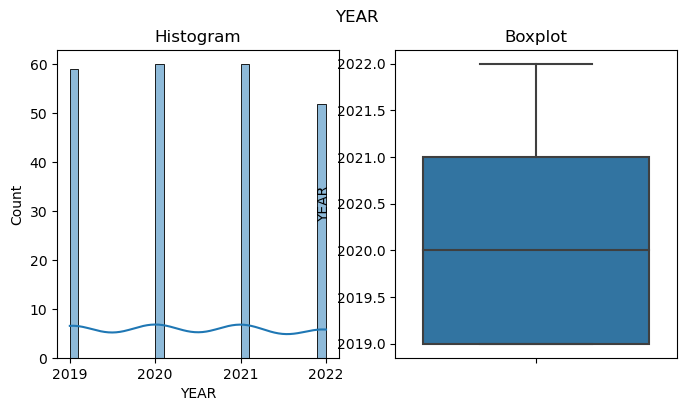

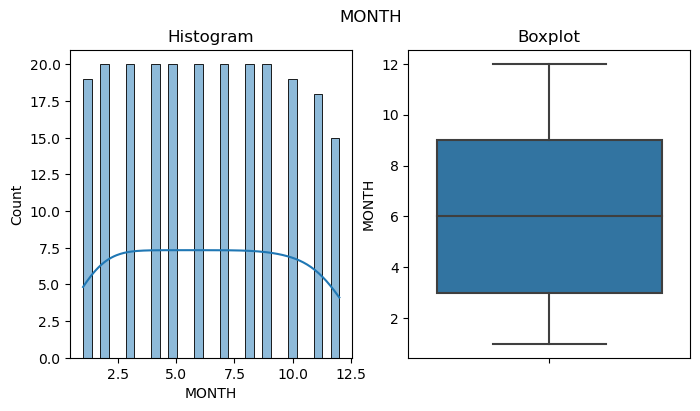

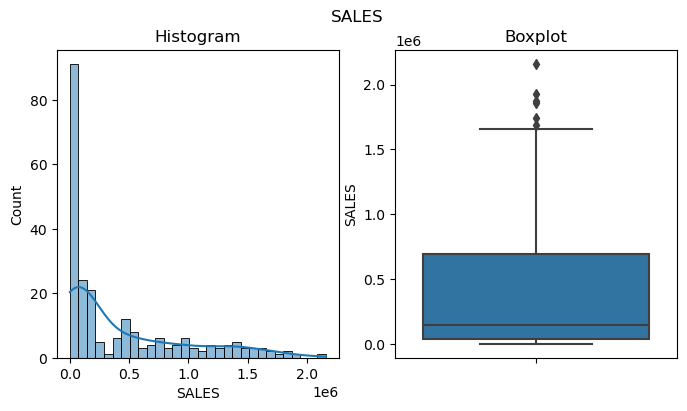

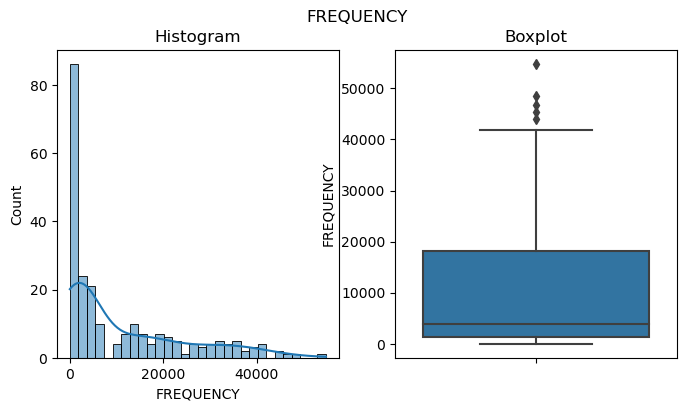

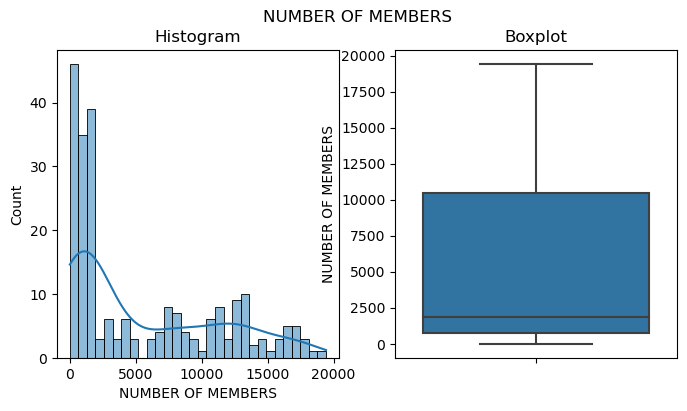

In [21]:
for i in num_cols:
    diagnostic_plots(train_df,i)
    plt.show()

### 3.2.3 Cap the Outliers

#### 3.2.3.1 Cap by gaussian

In [22]:
# create the capper
windsorizer = Winsorizer(capping_method='iqr', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['FREQUENCY'])

windsorizer.fit(train_df)

Winsorizer(capping_method='iqr', tail='both', variables=['FREQUENCY'])

In [23]:
train_df_win = windsorizer.transform(train_df)

Cap by gaussian for distributions with a normal ditribution. (Outliers = 3 Standard-deviations away)

# 4 Split the Data

In [38]:
# Train test split
X = train_df_win.drop(['SALES'],axis=1)
y = train_df_win["SALES"]


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.6,random_state=42)

In [39]:
# Test and holdout split
X_test,X_holdout,y_test,y_holdout=train_test_split(X_test,y_test,test_size=0.5,random_state=42)

## 4.1 Data Engineering 2

In [40]:
# One Hot Encoding 
ohe_enc = OneHotEncoder(
     top_categories=None,
     drop_last=True,
     variables=['CLUSTER']) 

ohe_enc.fit(X_train)
X_train = ohe_enc.transform(X_train)
X_test=ohe_enc.transform(X_test)
X_holdout=ohe_enc.transform(X_holdout)

### 4.1.2 Feature Scaling

#### 4.1.2.1 Min Max Scaler

In [41]:
# Min Max Scaler
cols_to_scale=X_train.columns

scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train[cols_to_scale])

# transform train and test sets
X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test[cols_to_scale]= scaler.transform(X_test[cols_to_scale])
X_holdout[cols_to_scale]=scaler.transform(X_holdout[cols_to_scale])

# 5. Model Building

## 5.1 Define Evaluation Function

In [42]:
def evaluateRegressionModelPerformance(model, X_train, X_test, X_holdout, y_train, y_test, y_holdout):
    # Training evaluation
    print('Training Set:')
    train_pred=model.predict(X_train)
    print('Mean Squared Error:', mean_squared_error(train_pred, y_train))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(train_pred, y_train)))
    print('R-squared:', r2_score(y_train, train_pred))
    print()

    # Testing evaluation
    print('Testing Set:')
    test_pred=model.predict(X_test)
    print('Mean Squared Error:', mean_squared_error(test_pred, y_test))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(test_pred, y_test)))
    print('R-squared:', r2_score(y_test, test_pred))
    print()

    # Holdout evaluation
    print('Holdout Set:')
    holdout_pred=model.predict(X_holdout)
    print('Mean Squared Error:', mean_squared_error(holdout_pred, y_holdout))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(holdout_pred, y_holdout)))
    print('R-squared:', r2_score(y_holdout, holdout_pred))

## Linear Regression

In [43]:
#Building LR Model
lm = LinearRegression()
lm.fit(X_train, y_train)
evaluateRegressionModelPerformance(lm, X_train, X_test, X_holdout, y_train, y_test, y_holdout)


Training Set:
Mean Squared Error: 407999121.38525116
Root Mean Squared Error: 20198.988127756576
R-squared: 0.9983628175334529

Testing Set:
Mean Squared Error: 401776683.0804831
Root Mean Squared Error: 20044.367864327454
R-squared: 0.9984957443171252

Holdout Set:
Mean Squared Error: 398348699.6682819
Root Mean Squared Error: 19958.674797397794
R-squared: 0.9987138310977037


## Decision Tree Regression

In [30]:
#Create Decision Tree Model
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=2)
tree_reg.fit(X_train, y_train)
evaluateRegressionModelPerformance(tree_reg, X_train, X_test, X_holdout, y_train, y_test, y_holdout)

Training Set:
Mean Squared Error: 12542495219.455103
Root Mean Squared Error: 111993.28202823196
R-squared: 0.9496705944112744

Testing Set:
Mean Squared Error: 10082079413.378778
Root Mean Squared Error: 100409.55837657477
R-squared: 0.9622525997863033

Holdout Set:
Mean Squared Error: 16197142242.29344
Root Mean Squared Error: 127267.99378592183
R-squared: 0.9477034550998775


## Random ForestRegression

In [31]:
#Create Random Forest Model
rf_reg = RandomForestRegressor(max_depth=2, random_state=1, n_estimators=20)
rf_reg.fit(X_train, y_train) 
evaluateRegressionModelPerformance(rf_reg, X_train, X_test, X_holdout, y_train, y_test, y_holdout)

Training Set:
Mean Squared Error: 8203960897.088111
Root Mean Squared Error: 90575.71913646677
R-squared: 0.9670798777915317

Testing Set:
Mean Squared Error: 5614294525.069435
Root Mean Squared Error: 74928.59617709006
R-squared: 0.978980028457806

Holdout Set:
Mean Squared Error: 15574790471.925385
Root Mean Squared Error: 124799.00028415846
R-squared: 0.949712874219365


## Ada Boost Regression

In [32]:
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2), 
                            n_estimators=200, 
                            learning_rate=0.5)

ada_reg.fit(X_train, y_train)
evaluateRegressionModelPerformance(ada_reg, X_train, X_test, X_holdout, y_train, y_test, y_holdout)

Training Set:
Mean Squared Error: 4482694510.106894
Root Mean Squared Error: 66952.92756935199
R-squared: 0.9820122434824955

Testing Set:
Mean Squared Error: 5879775463.825289
Root Mean Squared Error: 76679.69394712846
R-squared: 0.977986065324464

Holdout Set:
Mean Squared Error: 8252914091.13079
Root Mean Squared Error: 90845.55075033003
R-squared: 0.973353392477057


## XGBoost Regressor

In [33]:
xgb_before = XGBRegressor(max_depth=2, learning_rate = 0.1, use_label_encoder = False, eval_metric='logloss')
# fit the model to the training data
xgb_before.fit(X_train, y_train)

evaluateRegressionModelPerformance(xgb_before, X_train, X_test, X_holdout, y_train, y_test, y_holdout)

Training Set:
Mean Squared Error: 72917617.38562368
Root Mean Squared Error: 8539.181306520179
R-squared: 0.999707402691749

Testing Set:
Mean Squared Error: 1674688203.3027024
Root Mean Squared Error: 40922.954479151456
R-squared: 0.9937299516050887

Holdout Set:
Mean Squared Error: 2658450451.4924493
Root Mean Squared Error: 51560.16341607588
R-squared: 0.9914165245126884


In [34]:
param_grid = {'n_estimators': [30, 40, 50, 60],
              'learning_rate': [0.1, 0.2, 0.3, 0.4],
              'max_depth': [4,5,6,7]}

xgb_grid = GridSearchCV(xgb_before, param_grid, cv=5)
xgb_grid.fit(X_train, y_train)

print("Best parameters found: ", xgb_grid.best_params_)
print("Best score found: ", xgb_grid.best_score_)

Best parameters found:  {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 60}
Best score found:  0.9897665039509864


In [35]:
# Build XGBoost Model
xgb_improved = XGBRegressor(learning_rate = 0.2, max_depth =7, n_estimators = 60)
# fit the model to the training data
xgb_improved.fit(X_train, y_train)

evaluateRegressionModelPerformance(xgb_improved, X_train, X_test, X_holdout, y_train, y_test, y_holdout)

Training Set:
Mean Squared Error: 57156.17733521201
Root Mean Squared Error: 239.0735814246568
R-squared: 0.9999997706487919

Testing Set:
Mean Squared Error: 1858421653.5122714
Root Mean Squared Error: 43109.41490570559
R-squared: 0.9930420518382509

Holdout Set:
Mean Squared Error: 2525612592.1800666
Root Mean Squared Error: 50255.47325595558
R-squared: 0.9918454249304316


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

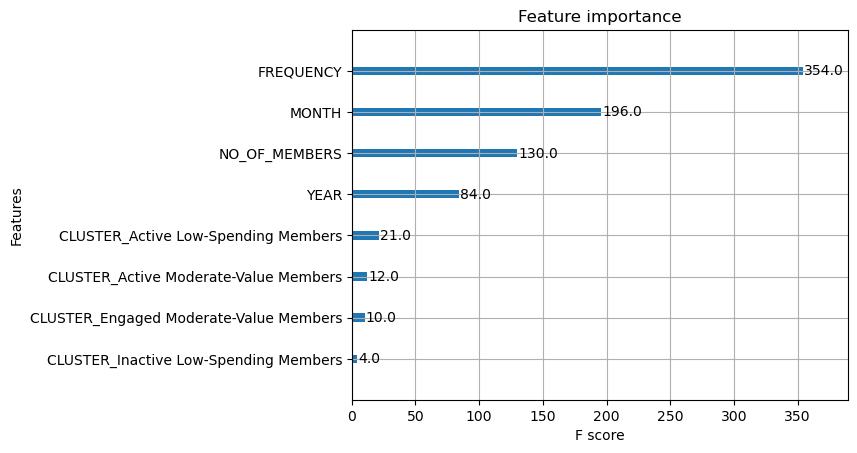

In [397]:
xgb.plot_importance(xgb_improved)